In [2]:
# !pip install bertopic
# !pip install sentence-transformers

In [3]:
import pandas as pd

from google.colab import drive
import os
import shutil
import zipfile

drive.mount("/content/gdrive/") # 지정 위치와 구글 드라이브 연결

Mounted at /content/gdrive/


In [4]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [5]:
file_path = '/content/gdrive/MyDrive/GMSW/project/data/'
df = pd.read_csv(file_path+'all_news_data_ssk.csv')
df.tail()

,href,title,date,content,key
13842,https://n.news.naver.com/mnews/article/032/000...,잘나가는 자회사 덕에 들썩…‘만년 저평가’ 지주사의 변신,2025-11-06 20:45,조선방산 신사업 호실적 영향에 두산한화 등 주가 올해 2배 이상자사주 의무소각상법개...,SK하이닉스
13843,https://n.news.naver.com/mnews/article/020/000...,“집 못살바엔 결혼자금 깨서 주식에”…불장 뛰어든 영끌 청년개미,2025-11-06 21:46,“집값 올라 월급-저축만으론 못사코스피 뛰자 위험 감수하고 증시로 신용대출에 마이너...,SK하이닉스
13844,https://n.news.naver.com/mnews/article/052/000...,"개미 사고 외국인 팔고...코스피, 4000선 앞 등락 반복",2025-11-06 22:54,전날 급락했던 코스피가 개인 투자자들의 저점 매수에 힘입어 반등에 성공했습니다하지만...,SK하이닉스
13845,https://n.news.naver.com/mnews/article/422/000...,"재계, 내년 경영전략 마련…'AI·관세 파고' 대응",2025-11-06 23:26,국내 주요 그룹들이 내년 경영전략을 세우고 있습니다AI 시대의 흐름을 놓치지 않으면...,SK하이닉스
13846,https://n.news.naver.com/mnews/article/422/000...,"네이버 ""쇼핑·검색에 AI 에이전트 도입…GPU 1조 투자""",2025-11-06 23:29,이제 첨단기업들의 미래는 AI를 빼고는 얘기할 수 없습니다국내에서도 치열한 경쟁이 ...,SK하이닉스


## 토픽모델링

### 모델학습

In [33]:
texts = df['content'].tolist()

# 불용어 리스트
my_stopwords = [
    '있다', '이날', '밝혔다', '따르면', '기자', '오전', '오후', '전일', '대비',
    '거래', '마감', '기록', '관련', '위해', '통해', '가장', '것으로', '보인다',
    '코스피', '포인트', '증권', '종목', '상승', '하락'
]

embedding_model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
vectorizer_model = CountVectorizer(stop_words=my_stopwords)

# 모델 생성 (min_topic_size 상향)
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model, # 불용어 적용
    min_topic_size=50,      # 50 (너무 작은 토픽 생성 방지)
    nr_topics=20,           # 자동으로 20개까지만 남기고 합치기
    top_n_words=10,
    verbose=True
)

# 학습
topics, probs = topic_model.fit_transform(texts)

2025-12-09 02:12:35,303 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/433 [00:00<?, ?it/s]

2025-12-09 02:14:25,875 - BERTopic - Embedding - Completed ✓
2025-12-09 02:14:25,876 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 02:14:37,465 - BERTopic - Dimensionality - Completed ✓
2025-12-09 02:14:37,467 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 02:14:38,181 - BERTopic - Cluster - Completed ✓
2025-12-09 02:14:38,182 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-09 02:14:43,082 - BERTopic - Representation - Completed ✓
2025-12-09 02:14:43,095 - BERTopic - Topic reduction - Reducing number of topics
2025-12-09 02:14:43,124 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 02:14:49,368 - BERTopic - Representation - Completed ✓
2025-12-09 02:14:49,383 - BERTopic - Topic reduction - Reduced number of topics from 46 to 20


In [43]:
topic_model.visualize_barchart()

In [44]:
topic_model.visualize_topics()

In [49]:
# 토픽 간 코사인 유사도 히트맵
# 특정 토픽끼리 뭉치는 경향을 파악할 수 있음
fig2 = topic_model.visualize_heatmap()

# 만약 토픽이 너무 많다면, 주요 토픽만 골라서 그릴 수도 있음
# fig2 = topic_model.visualize_heatmap(topics_to_ignore=[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]) # 노이즈 토픽 제외
fig2.show()

In [50]:
# 토픽들의 계층적 구조 시각화 (Dendrogram)
# 어떤 토픽들이 같은 그룹으로 묶이는지 확인
fig3 = topic_model.visualize_hierarchy()
fig3.show()

2025-12-09 02:18:03,077 - BERTopic - WARNING: No c-TF-IDF matrix was found despite it is supposed to be used (`use_ctfidf` is True). Defaulting to semantic embeddings.


In [ ]:
df['topic'] = topics
df[['date', 'content', 'topic']].head()

,date,content,topic
0,2025-09-26 00:00,문신학 산업통상자원부 차관이 일 서울 종로구 정부서울청사에서 마리나 데니슉 우크라이...,-1
1,2025-09-26 00:01,우리은행이 삼성전자의 디지털 결제 서비스인 삼성월렛 머니포인트 운영 사업자로 선정됐...,17
2,2025-09-26 00:30,김영호사진 삼성전자서비스 대표이사가 산업정책연구원이 주관하는한국경영대상에서 서비스 ...,4
3,2025-09-26 01:31,우리은행은 삼성전자의 디지털 결제 서비스인 삼성월렛 머니포인트의 단독 운영 은행으로...,17
4,2025-09-26 03:02,한번에 최대 개모델 비교 가능 삼성전자가 인공지능 모델의 성능을 측정해서 수치화하는...,-1


### save

In [ ]:
# df.to_csv('/content/gdrive/MyDrive/GMSW/project/result/news_topic_df_ssk.csv')

In [ ]:
# # 모델저장
# save_path = "/content/gdrive/MyDrive/GMSW/project/model/news_topic_model_ssk"
# topic_model.save(save_path, serialization="safetensors")

In [41]:
embedding_model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

In [51]:
# # 저장했던 모델 불러오기
# save_path = "/content/gdrive/MyDrive/GMSW/project/model/news_topic_model_ssk"
# topic_model = BERTopic.load(save_path)

# # 잘 불러와졌는지 확인 (토픽 정보 출력)
# topic_model.get_topic_info()

### 토픽 레이블 지정

| Topic ID | 연구자 정의 레이블 (Label) | 주요 키워드 (Keywords) | 성격 (Category) | 논문 활용 포인트 |
|---|---|---|---|---|
| Topic 0 | 시장 시황 및 랠리(Market Rally & Index) | "코스피, 사상, 오른, 대비, 장중" | 시황 (Overview) | 시장 전체의 과열 분위기를 보여주는 배경 변수 |
| Topic 1 | AI 반도체 산업 트렌드(AI & Semi Trend) | "AI, 반도체, 글로벌, 기술, 삼성전자" | 산업 테마 (Theme) | [핵심] 랠리를 관통하는 거대한 메가 트렌드 (상수) |
| Topic 2 | 리더십 및 협력 기대감(Leadership & Partnership) | "엔비디아, 젠슨(황), 이재용, CEO, 치맥" | 모멘텀 (Momentum) | [H3 핵심] 실적보다 강력한 '기대감' 기반의 상승 동력 |
| Topic 3 | 글로벌 거시 정치(Global Macro-Politics) | "트럼프, APEC, 미국, 회장, CEO" | 대외 변수 (Macro) | 미국 대선 및 국제 정세가 미친 영향 (통제 변수) |
| Topic 4 | 기업 실적 및 펀더멘털(Corporate Earnings) | "분기, 3분기, 실적, 매출, 메모리" | 펀더멘털 (Fundamental) | [H3 핵심] 랠리 초반을 주도했으나 후반에 힘이 빠지는 이성적 지표 |
| Topic 5 | 국내 투자 수급(Domestic Investment Flow) | "주식, 국내, ETF, 반도체, 투톱" | 수급 (Supply/Demand) | 개인 및 기관 투자자들의 자금 유입 경로 (ETF 등) |
| Topic 7 | 경영 승계 및 유산(Management Legacy) | "삼성, 이건희, 선대회장, 3주기" | 기업 이슈 (Event) | 故 이건희 회장 추모 등 삼성 내부 이벤트 (주가 영향 제한적) |
| Topic 8 | 가전 매출 및 마케팅(Consumer Electronics) | "최대, 할인, 혜택, 비스포크, 가전" | 노이즈 (Noise) | 반도체 주가와 직접 연관성이 낮은 가전 사업부 홍보 뉴스 |

<br><br>

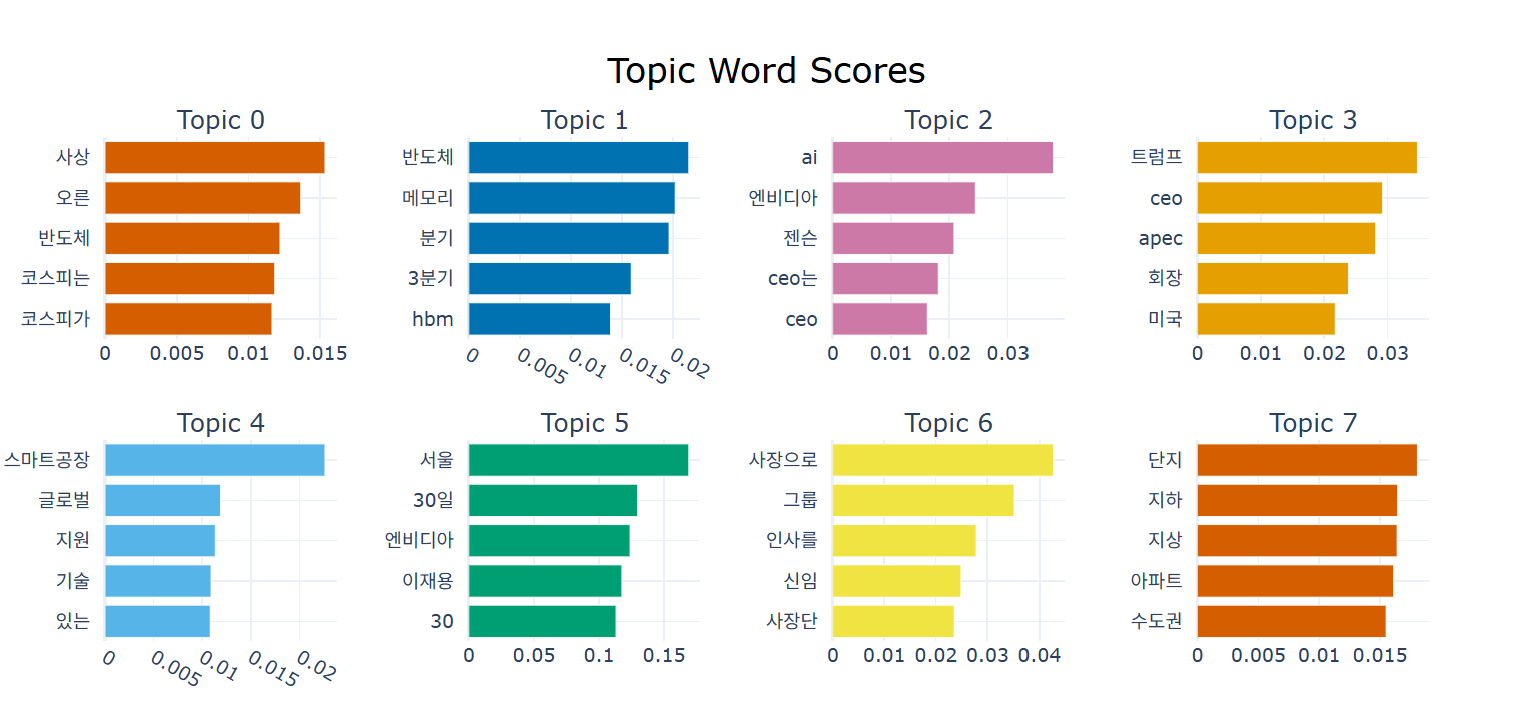

In [ ]:
# df[['topic']].value_counts()

In [ ]:
# # 1. 아웃라이어(Topic -1) 줄이기
# # strategy="c-tf-idf" 등을 쓰면 문맥상 가장 가까운 토픽으로 재배치해줍니다.
# new_topics = topic_model.reduce_outliers(texts, topics, strategy="c-tf-idf")

# # 2. 줄어든 결과로 토픽 업데이트
# topic_model.update_topics(texts, topics=new_topics)

# # 3. 다시 정보 확인 (Topic -1의 개수가 확 줄었는지 확인)
# topic_model.get_topic_info()

In [ ]:
# # 모델저장
# save_path = "/content/gdrive/MyDrive/GMSW/project/model/news_topic_model_ssk-reduce_outliers"
# topic_model.save(save_path, serialization="safetensors")

In [ ]:
topic_labels = {
    -1: "노이즈",
    0: "시황/랠리",
    1: "산업트렌드/실적/펀더멘털",
    2: "협력 기대감",
    3: "글로벌 거시 정치",
    4: "정책",
    5: "이벤트",
    6: "경영 승계/보상",
    7: "노이즈"
}

df['Topic_Name'] = df['topic'].map(topic_labels)

In [ ]:
# df.to_csv('/content/gdrive/MyDrive/GMSW/project/result/news_topic_df_ssk.csv')

### 토픽-주가 비교 시각화

In [ ]:
# 저장했던 모델 불러오기
save_path = "/content/gdrive/MyDrive/GMSW/project/model/news_topic_model_ssk"
topic_model = BERTopic.load(save_path)

# 모델이 기억하고 있는 토픽 정보(topics_)
current_topics = topic_model.topics_

# 텍스트와 토픽 정보를 이용해 '단어 가중치(c-TF-IDF)' 다시 계산
topic_model.update_topics(df['content'].tolist(), topics=current_topics)

# 잘 불러와졌는지 확인 (토픽 정보 출력)
topic_model.get_topic_info()

2025-12-08 07:35:41,448 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.
2025-12-08 07:35:41,452 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3252,-1_ai_삼성전자_글로벌_있는,"[ai, 삼성전자, 글로벌, 있는, 것으로, 통해, 있다, 반도체, 서울, 지난]",NaN
1,0,4612,0_코스피_사상_대비_오른,"[코스피, 사상, 대비, 오른, 상승, 반도체, 코스피는, 코스피가, 각각, 장중]",NaN
2,1,1753,1_반도체_메모리_분기_것으로,"[반도체, 메모리, 분기, 것으로, 3분기, hbm, ai, 실적, 올해, 대비]",NaN
3,2,1335,2_ai_엔비디아_젠슨_ceo는,"[ai, 엔비디아, 젠슨, ceo는, ceo, 이재용, 회장과, 회장은, 최고경영자...",NaN
4,3,470,3_트럼프_ceo_apec_회장,"[트럼프, ceo, apec, 회장, 미국, 것으로, 경주, 회장은, 주요, 그룹]",NaN
5,4,463,4_스마트공장_통해_글로벌_지원,"[스마트공장, 통해, 글로벌, 지원, 기술, 있다, 있는, 위해, 기업, 위한]",NaN
6,5,338,5_서울_30일_엔비디아_이재용,"[서울, 30일, 엔비디아, 이재용, 30, 10, 삼성전자, 회장정의선, 강남구,...",NaN
7,6,216,6_사장으로_그룹_인사를_신임,"[사장으로, 그룹, 인사를, 신임, 사장단, 인사, 경영, 사장은, 사장, 회장은]",NaN
8,7,209,7_단지_지하_지상_아파트,"[단지, 지하, 지상, 아파트, 수도권, 부동산, 84, 서울, 청약, 분양]",NaN
9,8,173,8_할인_최대_로봇청소기_혜택을,"[할인, 최대, 로봇청소기, 혜택을, 가전, 구매, 비스포크, 소비자, 청소기, 무선]",NaN


In [ ]:
# 시계열 분석 계산
texts = df['content'].tolist()
timestamps = df['date'].tolist()

topics_over_time = topic_model.topics_over_time(texts, timestamps, nr_bins=20)

20it [01:36,  4.81s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [ ]:
import datetime

topics_over_time['date'] = [time.strftime('%Y-%m-%d') for time in topics_over_time['Timestamp'].tolist()]
topics_over_time.head()

,Topic,Words,Frequency,Timestamp,Name,date
0,-1,"협력사, 명절을, ai, 통해, 협력사의",49,2025-09-25 22:59:33.060,-1_ai_삼성전자_글로벌_있는,2025-09-25
1,0,"코스피, 대비, 미국, 있다, 코스피는",121,2025-09-25 22:59:33.060,0_코스피_사상_대비_오른,2025-09-25
2,1,"반도체, 것으로, 중국, 있다, 메모리",21,2025-09-25 22:59:33.060,1_반도체_메모리_분기_것으로,2025-09-25
3,2,"ai, 투자, 한계기업, 엔비디아, 요약",8,2025-09-25 22:59:33.060,2_ai_엔비디아_젠슨_ceo는,2025-09-25
4,4,"최적화, 수학적, 통해, 그랜드, 있다",22,2025-09-25 22:59:33.060,4_스마트공장_통해_글로벌_지원,2025-09-25


In [ ]:
stock = pd.read_csv(file_path+'stock_price.csv')
# stock.head()

In [ ]:
# Min-Max 정규화
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

# 정규화된 컬럼 생성
stock['Scaled_samsung_price'] = min_max_scale(stock['samsung_price'])
stock['Scaled_skhynix_price'] = min_max_scale(stock['skhynix_price'])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 토픽 데이터 준비 (topics_over_time 결과 사용)
target_topics = [0, 1, 2, 3]
topic_labels = {
    0: "Topic 0: 시황/랠리",
    1: "Topic 1: 산업/실적/펀더멘털",
    2: "Topic 2: 협력기대감",
    3: "Topic 3: 매크로",
}

# 이중축 차트 그리기
# 보조축(Secondary Y)이 있는 피규어 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# [왼쪽 축] 토픽 빈도수 (막대 그래프 or 부드러운 선)
colors = ['#FFA07A', '#20B2AA', '#87CEFA', '#fbe383']

for i, topic_id in enumerate(target_topics):
    # 해당 토픽 데이터만 필터링
    topic_data = topics_over_time[topics_over_time['Topic'] == topic_id]

    fig.add_trace(
        go.Scatter(
            x=topic_data['Timestamp'],
            y=topic_data['Frequency'],
            name=topic_labels[topic_id],
            mode='lines', # 'lines' 또는 'lines+markers' 추천
            line=dict(width=2, color=colors[i]),
            fill='tozeroy', # 바닥까지 색칠하기 (영역 차트 느낌)
            opacity=0.5     # 투명도 조절 (주가가 잘 보이게)
        ),
        secondary_y=False # 왼쪽 축 사용
    )

In [ ]:
# [오른쪽 축] 주가 데이터 (선 그래프)
# 삼성전자
fig.add_trace(
    go.Scatter(
        x=stock['date'],
        y=stock['Scaled_samsung_price'],
        name="삼성전자 (Scaled)",
        mode='lines',
        line=dict(color='firebrick', width=2, dash='dot') #, dash='solid')
    ),
    secondary_y=True # 오른쪽 축 사용
)

# SK하이닉스 (필요하면 주석 해제)
fig.add_trace(
    go.Scatter(
        x=stock['date'],
        y=stock['Scaled_skhynix_price'],
        name="SK하이닉스 (Scaled)",
        mode='lines',
        line=dict(color='royalblue', width=2, dash='dot') # 점선으로 구분
    ),
    secondary_y=True
)

# 레이아웃 다듬기
fig.update_layout(
    title_text="<b>뉴스 토픽 변화와 주가 추세의 상관관계 (Min-Max Scaled)</b>",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(orientation="h", y=1.1, x=0.5, xanchor='center'), # 범례 위로 올리기
    height=600
)

fig.update_yaxes(title_text="<b>토픽 언급 빈도 (Frequency)</b>", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>주가 추세 강도 </b>", secondary_y=True, showgrid=True)

fig.show()

#### Granger Causality Test

In [ ]:
target_topic_id = 2
target_stock = stock[['date', 'skhynix_price']] # 분석할 주가: SK하이닉스

# 토픽 데이터 추출 (일별 빈도 합계)
topic_data = topics_over_time[topics_over_time['Topic'] == target_topic_id]
topic_daily = topic_data.set_index('date')['Frequency']
topic_daily

,Frequency
date,
2025-09-25,8
2025-09-28,21
2025-09-30,109
2025-10-02,44
2025-10-04,3
2025-10-06,4
2025-10-08,5
2025-10-10,29
2025-10-12,14


In [ ]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

# ---------------------------------------------------------
# 1. 데이터 준비 (분석할 토픽과 주가를 선택하세요)
# ---------------------------------------------------------
target_topic_id = 4  # 분석할 토픽: Topic 1 (AI 트렌드)
target_stock = stock[['date', 'skhynix_price']] # 분석할 주가: SK하이닉스

# 토픽 데이터 추출 (일별 빈도 합계)
topic_data = topics_over_time[topics_over_time['Topic'] == target_topic_id]
topic_daily = topic_data.set_index('date')['Frequency']

# topic_daily = topic_daily.reindex(target_stock['date'], fill_value=0)

# 데이터 병합 (날짜 기준 교집합)
df_analysis = pd.merge(topic_daily, target_stock, on='date').dropna()
df_analysis.columns = ['Date', 'Topic_Freq', 'Stock_Price']

# ---------------------------------------------------------
# 2. 정상성(Stationarity) 검정 & 차분(Differencing)
# ---------------------------------------------------------
# 시계열 데이터는 계속 오르는 추세(Trend)가 있으면 통계 오류가 납니다.
# 따라서 '전일 대비 변화량(Change)'으로 변환해야 합니다.

def check_stationarity(series):
    result = adfuller(series)
    return result[1] # p-value 반환 (0.05 이하면 정상성 확보)

# 로그 차분 (수익률 개념) 적용
df_diff = np.log(df_analysis[['Topic_Freq', 'Stock_Price']]).diff().dropna()

print(f"토픽 빈도 정상성 p-value: {check_stationarity(df_diff['Topic_Freq']):.4f}")
print(f"주가 수익률 정상성 p-value: {check_stationarity(df_diff['Stock_Price']):.4f}")
# 둘 다 0.05 이하여야 다음 단계로 넘어갑니다!

토픽 빈도 정상성 p-value: 0.0000
주가 수익률 정상성 p-value: 0.0000


In [ ]:
# ---------------------------------------------------------
# 3. 그레인저 인과관계 테스트
# ---------------------------------------------------------
# maxlag: 며칠 전 뉴스까지 볼 것인가? (보통 1주~2주 치인 5~10일 설정)
max_lag = 2

print(f"\n[검정 결과] Topic {target_topic_id} -> SK하이닉스 주가")
test_result = grangercausalitytests(df_diff[['Stock_Price', 'Topic_Freq']], maxlag=max_lag, verbose=True)

# 파라미터 순서: [종속변수(결과), 독립변수(원인)] -> 'Topic_Freq'가 'Stock_Price'를 선행하는지


[검정 결과] Topic 4 -> SK하이닉스 주가

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5321  , p=0.4894  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.7602  , p=0.3833  , df=1
likelihood ratio test: chi2=0.7327  , p=0.3920  , df=1
parameter F test:         F=0.5321  , p=0.4894  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1210  , p=0.8891  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=0.5447  , p=0.7616  , df=2
likelihood ratio test: chi2=0.5289  , p=0.7676  , df=2
parameter F test:         F=0.1210  , p=0.8891  , df_denom=4, df_num=2


In [ ]:
noise_topics = [0, 1, 2, 3, 4, 5]

df_clean = df[df['topic'].isin(noise_topics)].copy()
# df_clean = df_clean[df_clean['Sentiment_Score']>=0.5].copy()

print(f"원본 데이터: {len(df)}개 -> 정제된 데이터: {len(df_clean)}개")

# 이벤트 시작일 지정
event_start_date = "2025-10-16"

# 날짜 형식 변환
df_clean['date'] = pd.to_datetime(df_clean['date'])
threshold_date = pd.to_datetime(event_start_date)

# Pre: 이벤트 이전 / Post: 이벤트 이후 (급등 구간)
group_pre = df_clean[df_clean['date'] < threshold_date]
group_post = df_clean[df_clean['date'] >= threshold_date]

print(f"분석 기간 설정: {event_start_date} 기준")
print(f"Pre-Event 표본 수: {len(group_pre)}개")
print(f"Post-Event 표본 수: {len(group_post)}개")

원본 데이터: 13847개 -> 정제된 데이터: 8971개
분석 기간 설정: 2025-10-16 기준
Pre-Event 표본 수: 2640개
Post-Event 표본 수: 6331개


In [ ]:
import plotly.express as px

# 시각화를 위한 히스토그램 (Histogram)
# barmode='overlay': 두 그래프를 겹쳐서 비교
# histnorm='probability density': 데이터 개수가 달라도 비율로 비교 가능하게 함

df_clean['Period'] = df_clean['date'].apply(
    lambda x: 'Post-Event' if x >= threshold_date else 'Pre-Event'
)
# 1. 기간(Pre/Post)별 토픽 비중 계산
topic_dist = df_clean.groupby(['Period', 'Topic_Name']).size().reset_index(name='Count')

# 2. 비율(%)로 변환
topic_dist['Percentage'] = topic_dist.groupby('Period')['Count'].transform(lambda x: x / x.sum())

# 3. 시각화 (100% Stacked Bar Chart)
fig = px.bar(topic_dist,
             x='Period',
             y='Percentage',
             color='Topic_Name',
             title="<b>이벤트 전후 뉴스 토픽 구성 변화 (Composition Shift)</b>",
             text_auto='.1%',
             category_orders={"Period": ["Pre-Event", "Post-Event"]} # 순서 고정
            )

fig.update_layout(
    yaxis_title="비중 (%)",
    template="plotly_white",
    legend=dict(orientation="h", y=1.1, x=0, xanchor='left'), # 범례 위로 올리기
)

fig.show()